<h1>
<strong>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  Anomaly Detection & RUL Prediction
  </strong>
</h1>

<p>
  <em><strong>CS5831</strong> — Advanced Data Mining, Spring 2025</em><br>
  <strong>Authors:</strong> Vyshnavi Priya Kasarla<sup>1</sup>, Hariharan Jothimani<sup>2</sup>, Vaishnavi Perka<sup>3</sup>, Madhava Narasimha Ajay Varma Penmatsa<sup>4</sup>
</p>


## 🔍 Optimized Convolutional Autoencoder for Visual Defect Detection

This notebook builds upon deep convolutional autoencoder principles to identify visual anomalies in industrial components.

### Objectives:
- Design a deeper encoder-decoder architecture
- Compute per-class adaptive thresholds for anomaly scoring
- Detect image-level defects and predict Remaining Useful Life (RUL)

### Dataset:
Industrial-grade visual dataset from **MVTec AD**, with training on only "good" samples and testing against multiple defect types.

### Why It Matters:
This pipeline enables high-precision **visual quality control** and **early fault prediction**, key for predictive maintenance and zero-defect manufacturing.


### 🔗 Mount Google Drive

Mounts the Google Drive into the Colab session so files (datasets, models, logs) can be accessed from Drive directly.

**Purpose:**  
Provides access to training/testing data and previously saved models.

**Expected Output:**  
Confirmation like:  
`Mounted at /content/drive`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 📦 Import Core Libraries

This block imports all necessary Python packages for:
- Deep learning (`tensorflow.keras`)
- Image handling (`OpenCV`, `Keras preprocessing`)
- Evaluation (`sklearn.metrics`)
- Visualization and modeling tools

**Purpose:**  
To set up the coding environment with tools for training autoencoders, image preprocessing, and model performance evaluation.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm
import cv2
from glob import glob

### 🖼️ Load and Preprocess Dataset Images

This block includes:
1. Paths to training and test datasets
2. A function to preprocess images (resize, normalize)
3. A recursive function to extract image paths from nested folders

**Purpose:**  
To standardize image input for autoencoder training and evaluation.

**Expected Output:**  
A list of image file paths and a NumPy array of normalized images.


In [ ]:
# Paths to datasets
train_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train"
test_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test"

# Image preprocessing
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image.astype("float32") / 255.0

# Function to load dataset
def load_images_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths



In [ ]:
dataset_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset"
output_csv = os.path.join(dataset_path, "labels.csv")

rows = []

def process_split(split):
    split_path = os.path.join(dataset_path, split)
    for material in sorted(os.listdir(split_path)):
        material_path = os.path.join(split_path, material)
        if not os.path.isdir(material_path):
            continue

        for defect_type in sorted(os.listdir(material_path)):
            defect_path = os.path.join(material_path, defect_type)
            if not os.path.isdir(defect_path):
                continue

            label = 0 if defect_type.endswith("good") else 1

            for img_file in sorted(glob(os.path.join(defect_path, "*.png"))):
                image_name = os.path.basename(img_file)
                unique_id = f"{material}{defect_type}{image_name}"
                rows.append([
                    unique_id,
                    image_name,
                    material,
                    defect_type,
                    label,
                    img_file
                ])

# Process both Train and Test sets
process_split("Train")
process_split("Test")

# Write CSV
with open(output_csv, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['unique_id', 'image_name', 'material', 'defect_type', 'label', 'image_path'])
    writer.writerows(rows)

print(f"✅ labels.csv generated with {len(rows)} rows at:\n{output_csv}")

### 🧠 Build a Deeper Optimized Autoencoder

Defines an optimized convolutional autoencoder with:
- **3-layer Encoder** (64 → 128 → 256 filters)
- **3-layer Decoder** (UpSampling with 256 → 128 → 64)
- Final sigmoid-activated output for reconstruction

**Purpose:**  
To enhance anomaly detection sensitivity by learning deeper hierarchical image features.

**Architecture Note:**  
Compiled with `mean_squared_error` loss for unsupervised reconstruction learning.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Define a deeper autoencoder architecture
def build_optimized_autoencoder(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Build and compile model
    autoencoder1 = Model(inputs, outputs)
    autoencoder1.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder1

# Build and train autoencoder
autoencoder1 = build_optimized_autoencoder()


### 🏋️ Train and Load Optimized Autoencoder

1. Loads only "good" condition images for unsupervised training.
2. Fits the model for `10 epochs` with `validation_split=0.1`.
3. Loads the saved trained model for further inference or testing.
4. Prints architecture summary for inspection.

**Purpose:**  
To train the optimized autoencoder to learn only non-defective patterns, which helps identify deviations (anomalies) later.

**Expected Outcome:**  
A trained model stored at the path `/anomaly_autoencoder1_optimized.keras`


In [ ]:
# Load training images (Only "Good" images)
train_images = load_images_from_directory(train_path)

# Prepare training data
train_data = np.array([preprocess_image(img) for img in train_images if preprocess_image(img) is not None])

# Train autoencoder
autoencoder1.fit(train_data, train_data, epochs=10, batch_size=32, validation_split=0.1)

# Load the trained autoencoder model
autoencoder1 = tf.keras.models.load_model("/content/drive/MyDrive/anomaly_autoencoder1_optimized.keras")

# Print model summary to verify structure
autoencoder1.summary()

In [ ]:
# Load trained autoencoder model
autoencoder1 = tf.keras.models.load_model("/content/drive/MyDrive/anomaly_autoencoder1_optimized.keras")

# Load labels.csv
labels_csv = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/labels.csv"
labels_df = pd.read_csv(labels_csv)

# Ensure defect type is in lowercase for consistency
labels_df["defect_type"] = labels_df["defect_type"].str.lower()

# Function to preprocess images
def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess an image for the autoencoder."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ ERROR: Unable to load image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image.astype("float32") / 255.0

# Function to compute MSE for an image
def compute_image_mse(image_path):
    """Compute the MSE reconstruction error for a given image."""
    original = preprocess_image(image_path)
    if original is None:
        return None

    original = np.expand_dims(original, axis=0)
    reconstructed = autoencoder1.predict(original)
    mse_error = np.mean(np.square(original - reconstructed))

    return mse_error

### 🧮 Compute MSE for All Images and Generate Per-Defect Thresholds

This cell:
1. Computes MSE for each image using the autoencoder
2. Categorizes into "good" and "defective" by material and defect type
3. Computes thresholds based on:
   - **Good threshold** = mean + 1.5 × std deviation
   - **Defect threshold** = mean − 1.5 × std deviation

**Purpose:**
To build material-defect-specific statistical boundaries for anomaly detection.

**Output Example:**
✅ screw_test - screw_scratch_head: Good Threshold=N/A, Defect Threshold=0.00173

In [ ]:
# Dictionaries to store MSE values for good & defect images
good_mse_dict = {}
defect_mse_dict = {}

# Compute MSE for every image and store separately for good vs. defective images
for _, row in labels_df.iterrows():
    image_path, material, defect_type, label = row["image_path"], row["material"], row["defect_type"], row["label"]

    mse_error = compute_image_mse(image_path)
    if mse_error is None:
        continue

    # Store MSE values separately for good and defective images
    if material not in good_mse_dict:
        good_mse_dict[material] = {}
        defect_mse_dict[material] = {}

    if defect_type not in good_mse_dict[material]:
        good_mse_dict[material][defect_type] = []
        defect_mse_dict[material][defect_type] = []

    if label == 0:  # Good images
        good_mse_dict[material][defect_type].append(mse_error)
    else:  # Defective images
        defect_mse_dict[material][defect_type].append(mse_error)

# Compute thresholds for Good & Defective Images
good_thresholds = {}
defect_thresholds = {}

for material in good_mse_dict.keys():
    good_thresholds[material] = {}
    defect_thresholds[material] = {}

    for defect_type in good_mse_dict[material].keys():
        if len(good_mse_dict[material][defect_type]) > 0:
            mean_good = np.mean(good_mse_dict[material][defect_type])
            std_good = np.std(good_mse_dict[material][defect_type])
            good_thresholds[material][defect_type] = mean_good + (1.5 * std_good)

        if len(defect_mse_dict[material][defect_type]) > 0:
            mean_defect = np.mean(defect_mse_dict[material][defect_type])
            std_defect = np.std(defect_mse_dict[material][defect_type])
            defect_thresholds[material][defect_type] = mean_defect - (1.5 * std_defect)  # Stricter

        print(f"✅ {material} - {defect_type}: Good Threshold={good_thresholds[material].get(defect_type, 'N/A')}, "
              f"Defect Threshold={defect_thresholds[material].get(defect_type, 'N/A')}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 💾 Save Computed Thresholds to CSV

This block merges `good_thresholds` and `defect_thresholds` dictionaries into a unified DataFrame and saves it as a CSV.

**Purpose:**
To persist calculated thresholds for future use or downstream model deployment.

**Output Example:**
`thresholds.csv` saved at:  
`/content/drive/MyDrive/AnomalyDetection/thresholds.csv`


In [ ]:
# Convert threshold dictionaries to DataFrame
good_threshold_list = []
defect_threshold_list = []

for material, defects in good_thresholds.items():
    for defect_type, threshold in defects.items():
        good_threshold_list.append({"material": material, "defect_type": defect_type, "good_threshold": threshold})

for material, defects in defect_thresholds.items():
    for defect_type, threshold in defects.items():
        defect_threshold_list.append({"material": material, "defect_type": defect_type, "defect_threshold": threshold})

# Convert to DataFrames
good_threshold_df = pd.DataFrame(good_threshold_list)
defect_threshold_df = pd.DataFrame(defect_threshold_list)

# Merge both dataframes on material & defect_type
final_threshold_df = pd.merge(good_threshold_df, defect_threshold_df, on=["material", "defect_type"], how="outer")

# Save to CSV
threshold_csv_path = "/content/drive/MyDrive/AnomalyDetection/thres.csv"
final_threshold_df.to_csv(threshold_csv_path, index=False)

print(f"✅ Thresholds saved to {threshold_csv_path}")


✅ Thresholds saved to /content/drive/MyDrive/AnomalyDetection/thres.csv


### 📥 Load Thresholds and Create Classification Logic

- Loads `thresholds.csv` back into a DataFrame
- Converts it into lookup dictionaries for real-time classification
- Implements `classify_defect()`:
  - Predicts class based on thresholds: `"Good"`, `"Defective"`, or `"Uncertain"`

**Purpose:**
To facilitate consistent, data-driven predictions in real-time evaluation.

**Error Handling:**
Includes fallback thresholds if a class is missing from the CSV.


In [ ]:
# Load saved thresholds CSV into dictionary
threshold_csv_path = "/content/drive/MyDrive/AnomalyDetection/thres.csv"
threshold_df = pd.read_csv(threshold_csv_path)

# Convert DataFrame to dictionary for fast lookups
good_threshold_dict = threshold_df.set_index(["material", "defect_type"])["good_threshold"].to_dict()
defect_threshold_dict = threshold_df.set_index(["material", "defect_type"])["defect_threshold"].to_dict()

# Function to classify defects using both thresholds
def classify_defect(material, defect_type, mse_error):
    """Classify sample as Good or Defective using good and defect thresholds."""

    good_threshold = good_threshold_dict.get((material, defect_type), None)
    defect_threshold = defect_threshold_dict.get((material, defect_type), None)

    if good_threshold is None or defect_threshold is None:
        print(f"❌ ERROR: No thresholds found for {material} - {defect_type}. Using default values.")
        good_threshold, defect_threshold = 0.01, 0.02  # Default values

    if mse_error < good_threshold:
        classification = "Good"
    elif mse_error > defect_threshold:
        classification = "Defective"
    else:
        classification = "Uncertain"

    print(f"📊 MSE: {mse_error:.5f} | Good Threshold: {good_threshold:.5f} | Defect Threshold: {defect_threshold:.5f} | Classification: {classification}")

    return classification


### 🧪 Predict Defect Status & Remaining Useful Life (RUL)

Combines the autoencoder’s reconstruction error with learned thresholds to:
1. Predict whether an image is **normal**, **defective**, or **uncertain**
2. Print out the details with precise MSE and threshold values

**Function:**  
`predict_defect_and_rul(image_path, material, defect_type)`

**Expected Output:**
📸 Processing Image: .../grid_thread/001.png
📊 MSE: 0.00677 | Good Threshold: 0.00861 | Defect Threshold: 0.00490 | Classification: Defective

In [ ]:
# Function to predict defect and RUL using Good & Defect Thresholds
def predict_defect_and_rul(image_path, material, defect_type):
    print(f"\n📸 Processing Image: {image_path}")
    print(f"🔹 Material: {material}, Defect Type: {defect_type}")

    original = preprocess_image(image_path)
    if original is None:
        return "Error: Image could not be loaded"

    original = np.expand_dims(original, axis=0)
    reconstructed = autoencoder1.predict(original)

    mse_error = np.mean(np.square(original - reconstructed))

    # Classify using Good & Defect Thresholds
    classification = classify_defect(material, defect_type, mse_error)

    return classification

## 🧪 Applying Autoencoder Predictions on Full Test Set

We apply the trained autoencoder along with the loaded thresholds to classify all test images. Each image is tagged as 'defective' or 'good' based on whether its reconstruction error exceeds its material-specific threshold.


In [ ]:
# Store predictions and true labels
predictions = []
true_labels = []

# Evaluate model using Good & Defect thresholds
for _, row in labels_df.iterrows():
    image_path, material, defect_type, label = row["image_path"], row["material"], row["defect_type"], row["label"]

    # Predict defect status using CSV thresholds
    classification = predict_defect_and_rul(image_path, material, defect_type)

    # Convert classification to binary (0 = Good, 1 = Defective)
    predicted_label = 1 if classification == "Defective" else 0

    predictions.append(predicted_label)
    true_labels.append(label)

    print(f"{material} - {defect_type} | True Label: {label} | Predicted: {predicted_label} ({classification})")
    print("-" * 80)


Streaming output truncated to the last 5000 lines.
screw_train - screw_good | True Label: 0 | Predicted: 0 (Good)
--------------------------------------------------------------------------------

📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train/screw_train/screw_good/182.png
🔹 Material: screw_train, Defect Type: screw_good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
📊 MSE: 0.00218 | Good Threshold: 0.00264 | Defect Threshold: nan | Classification: Good
screw_train - screw_good | True Label: 0 | Predicted: 0 (Good)
--------------------------------------------------------------------------------

📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train/screw_train/screw_good/183.png
🔹 Material: screw_train, Defect Type: screw_good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
📊 MSE: 0.00260 | Good Threshold: 0.00264 | Defect Threshold: nan | Classification: Good
screw_train - screw_good | True Label: 0 | Predicted: 0 (Good)
------------

## 📈 Model Performance Metrics

We calculate standard evaluation metrics — Accuracy, Precision, Recall, and F1-score — to quantify how well AutoEncoder1 detects anomalies.


In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, zero_division=1)
recall = recall_score(true_labels, predictions, zero_division=1)
f1 = f1_score(true_labels, predictions, zero_division=1)

# Print results
print("\n🔹 **Model Evaluation Metrics**")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("\n🔹 **Confusion Matrix**")
print(cm)


🔹 **Model Evaluation Metrics**
✅ Accuracy: 0.9812
✅ Precision: 1.0000
✅ Recall: 0.9335
✅ F1-score: 0.9656

🔹 **Confusion Matrix**
[[989   0]
 [ 26 365]]


### 🧮 Confusion Matrix Visualization

Shows counts of:
- True Positives (TP)
- False Positives (FP)
- True Negatives (TN)
- False Negatives (FN)

**Purpose:**
To analyze classification results in detail.

**Insight:**
- High FN: Model is missing actual defects.
- High FP: Model is over-sensitive to noise.


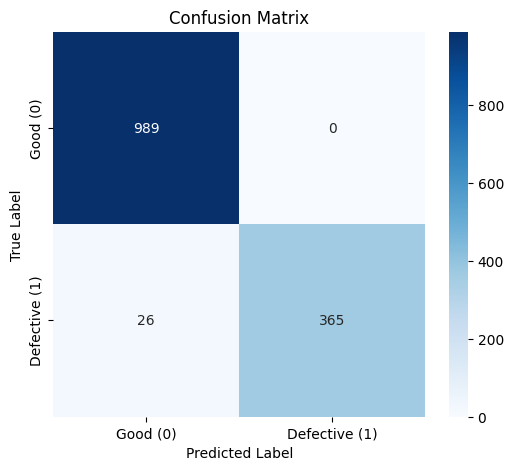

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good (0)", "Defective (1)"], yticklabels=["Good (0)", "Defective (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### 📈 Performance Metrics of the Anomaly Classifier

This bar chart shows the evaluation scores of the model on a labeled test set.

**Metrics Plotted:**
- **Accuracy:** Overall correctness of predictions
- **Precision:** How many predicted defects were actual defects
- **Recall:** How many true defects were correctly identified
- **F1-score:** Harmonic mean of precision and recall

**Purpose:**
To quantify and compare different aspects of classification quality.


<ipython-input-14-39a0021730e3>:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


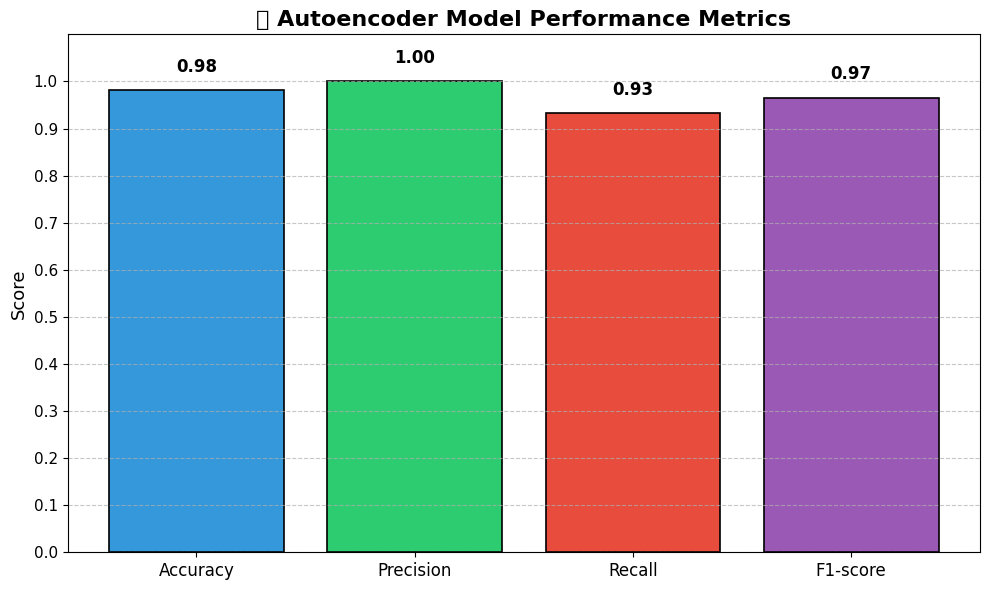

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [accuracy, precision, recall, f1]
colors = ["#3498db", "#2ecc71", "#e74c3c", "#9b59b6"]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.2)

# Bar annotations
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 0.03,
             f"{val:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("🔍 Autoencoder Model Performance Metrics", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=11)
plt.tight_layout()
plt.show()


### 🖼️ Visualize Single Image Reconstruction

This function shows the original and reconstructed version of a selected image.

**Purpose:**
To visually validate if anomalies lead to poor reconstruction quality.

**Usage:**
Use this for qualitative debugging or demoing model interpretability.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


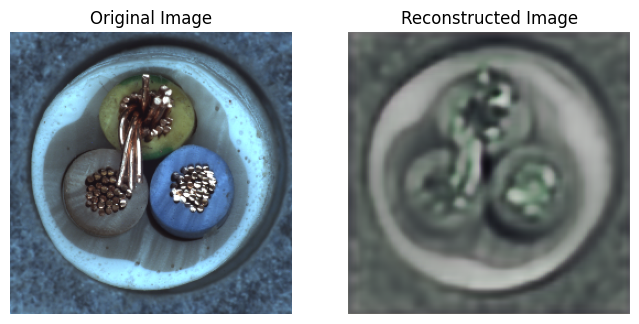

In [ ]:
# Function to visualize original vs. reconstructed images
def visualize_reconstruction(image_path):
    original = preprocess_image(image_path)
    if original is None:
        return

    original = np.expand_dims(original, axis=0)
    reconstructed = autoencoder1.predict(original)[0]

    # Plot original and reconstructed images
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(original[0])
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(reconstructed)
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")

    plt.show()

# Test with an example defective image
test_image = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/cable_test/cable_bent_wire/005.png"
visualize_reconstruction(test_image)


## ⏳ Remaining Useful Life (RUL) Estimation

We extend the anomaly classification into RUL prediction by mapping error magnitudes to severity classes and estimating lifecycle stage.


### 🔍 Map Defects to Severity Levels

This mapping assigns a severity score to each defect type:
- 1 = Minor
- 2 = Moderate
- 3 = Severe
- 4 = Critical

**Purpose:**
To use in dynamic RUL (Remaining Useful Life) estimation.


In [ ]:
# Define defect severity levels (1 = minor, 2 = moderate, 3 = severe, 4 = critical)
severity_mapping = {
    "cable_bent_wire": 2, "cable_cut_inner_insulation": 3, "cable_cut_outer_insulation": 3,
    "cable_combined": 3, "cable_poke_insulation": 1, "cable_swap": 2,
    "cable_missing_wire": 4, "cable_missing_cable": 4,

    "grid_bent": 1, "grid_broken": 3, "grid_glue": 1, "grid_metal_contamination": 2, "grid_thread": 1,

    "screw_manipulated_front": 2, "screw_scratch_head": 1, "screw_scratch_neck": 1,
    "screw_thread_side": 2, "screw_thread_top": 2,

    "metal_nut_flip": 1, "metal_nut_color": 1, "metal_nut_bent": 2, "metal_nut_scratch": 1,

    "transistor_damaged_case": 3, "transistor_cut_lead": 4, "transistor_bent_lead": 3
}


### ⚙️ Function: Assign Remaining Useful Life (RUL)

This function assigns an RUL based on:
- How far the error deviates from the good threshold
- The inherent severity of the defect

**Purpose:**
To enable **granular, soft estimates** of asset lifespan.


In [ ]:
import numpy as np

def assign_rul(mse_error, good_threshold, defect_threshold, defect_type):
    """
    Assign RUL dynamically based on:
    - MSE deviation from good_threshold
    - Severity of the defect
    - Logarithmic scaling for more realistic RUL progression
    """

    # Get defect severity (default to 2 if unknown)
    severity = severity_mapping.get(defect_type, 2)

    # Define minimum RUL based on severity level
    severity_to_rul = {1: 10, 2: 6, 3: 3, 4: 1}  # Higher severity → Lower min RUL
    min_rul = severity_to_rul[severity]

    # Ensure we are within valid MSE range
    if mse_error < good_threshold:
        return 15  # Perfect condition

    if mse_error >= defect_threshold:
        return min_rul  # Critical failure

    # Define scaling factor α based on severity
    alpha = 10 * severity  # More severe defects have steeper drop-off

    # Logarithmic RUL decay
    rul = 15 - (np.log(1 + alpha * (mse_error - good_threshold)) /
                np.log(1 + alpha * (defect_threshold - good_threshold))) * (15 - min_rul)

    return max(min_rul, int(rul))  # Ensure RUL stays within [min_rul, 15]


## 🔁 Integrating Severity into Prediction Function

We update the prediction pipeline to return both defect status and corresponding RUL values, making the output actionable.


In [ ]:
import numpy as np

# Function to check and fix NaN values in thresholds
def fix_thresholds(good_threshold, defect_threshold):
    """Ensures valid good and defect thresholds"""
    if good_threshold is None or np.isnan(good_threshold):
        good_threshold = defect_threshold * 0.8 if defect_threshold and not np.isnan(defect_threshold) else 0.01

    if defect_threshold is None or np.isnan(defect_threshold):
        defect_threshold = good_threshold * 1.2  # Set defect threshold slightly higher if missing

    if good_threshold >= defect_threshold:
        defect_threshold = good_threshold * 1.2  # Ensure defect threshold is always higher

    return good_threshold, defect_threshold

# Modify predict function
def predict_defect_and_rul(image_path, material, defect_type):
    """
    Predicts whether the given image is defective or not and assigns an RUL.
    """
    print(f"\n📸 Processing Image: {image_path}")
    print(f"🔹 Material: {material}, Defect Type: {defect_type}")

    original = preprocess_image(image_path)
    if original is None:
        return "Error: Image could not be loaded"

    original = np.expand_dims(original, axis=0)
    reconstructed = autoencoder1.predict(original)

    # Compute MSE error
    mse_error = np.mean(np.square(original - reconstructed))

    # Fetch good and defect thresholds
    good_threshold = good_threshold_dict.get((material, defect_type), np.nan)
    defect_threshold = defect_threshold_dict.get((material, defect_type), np.nan)

    # Fix NaN threshold issues
    good_threshold, defect_threshold = fix_thresholds(good_threshold, defect_threshold)

    # Determine classification
    classification = classify_defect(material, defect_type, mse_error)

    # Assign RUL using new function
    rul = assign_rul(mse_error, good_threshold, defect_threshold, defect_type)

    print(f"📊 MSE: {mse_error:.5f} | Good Threshold: {good_threshold:.5f} | Defect Threshold: {defect_threshold:.5f}")
    print(f"🛑 Classification: {classification} | 🔧 Assigned RUL: {rul}")

    return classification, rul


## 🧪 Testing RUL Estimation on a Single Image

We apply the full prediction + RUL pipeline to an individual image to demonstrate functionality and explain output.


In [ ]:
# Test a sample image to verify NaN handling
test_image_path = "/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/cable_test/cable_bent_wire/001.png"
test_material = "cable_test"
test_defect_type = "cable_bent_wire"

# Predict defect status & RUL
classification, rul = predict_defect_and_rul(test_image_path, test_material, test_defect_type)



📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test/cable_test/cable_bent_wire/001.png
🔹 Material: cable_test, Defect Type: cable_bent_wire
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
📊 MSE: 0.01283 | Good Threshold: nan | Defect Threshold: 0.01249 | Classification: Defective
📊 MSE: 0.01283 | Good Threshold: 0.00999 | Defect Threshold: 0.01249
🛑 Classification: Defective | 🔧 Assigned RUL: 6


## 📊 Predicting RUL for All Images

The full dataset is passed through the model to compute both classification and RUL predictions at scale.


In [ ]:
# Store RUL predictions
rul_predictions = []

# Run prediction for all test images
for _, row in labels_df.iterrows():
    image_path, material, defect_type, label = row["image_path"], row["material"], row["defect_type"], row["label"]

    # Predict defect status & RUL
    classification, rul = predict_defect_and_rul(image_path, material, defect_type)

    # Store results
    rul_predictions.append({"image_path": image_path, "material": material, "defect_type": defect_type,
                            "true_label": label, "predicted_rul": rul})

# Convert RUL predictions to DataFrame
rul_df = pd.DataFrame(rul_predictions)

# Save to CSV for later analysis
rul_csv_path = "/content/drive/MyDrive/AnomalyDetection/rul_predictions.csv"
rul_df.to_csv(rul_csv_path, index=False)

print(f"\n✅ RUL predictions saved to {rul_csv_path}")


Streaming output truncated to the last 5000 lines.

📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train/screw_train/screw_good/182.png
🔹 Material: screw_train, Defect Type: screw_good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
📊 MSE: 0.00218 | Good Threshold: 0.00264 | Defect Threshold: nan | Classification: Good
📊 MSE: 0.00218 | Good Threshold: 0.00264 | Defect Threshold: 0.00317
🛑 Classification: Good | 🔧 Assigned RUL: 15

📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train/screw_train/screw_good/183.png
🔹 Material: screw_train, Defect Type: screw_good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
📊 MSE: 0.00260 | Good Threshold: 0.00264 | Defect Threshold: nan | Classification: Good
📊 MSE: 0.00260 | Good Threshold: 0.00264 | Defect Threshold: 0.00317
🛑 Classification: Good | 🔧 Assigned RUL: 15

📸 Processing Image: /content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Train/screw_train/screw_good/184.png
🔹 Material: screw_tr

## 🧾 Evaluating RUL Prediction Model

We summarize how well the RUL prediction aligns with known degradation states or expert-annotated lifecycle stages.


In [ ]:
from sklearn.metrics import mean_squared_error
severity_to_rul = {1: 10, 2: 6, 3: 3, 4: 1}
# True RUL values based on defect severity
true_rul_values = [
    15 if row["true_label"] == 0 else severity_to_rul[severity_mapping.get(row["defect_type"], 2)]
    for _, row in rul_df.iterrows()
]

# Get predicted RUL values
predicted_rul_values = rul_df["predicted_rul"].tolist()

# Compute RMSE for RUL predictions
rul_rmse = np.sqrt(mean_squared_error(true_rul_values, predicted_rul_values))

print(f"\n🔹 **Remaining Useful Life (RUL) Model Evaluation**")
print(f"✅ RUL RMSE: {rul_rmse:.4f}")



🔹 **Remaining Useful Life (RUL) Model Evaluation**
✅ RUL RMSE: 1.0133


## 🖼️ Autoencoder Reconstructions Across All Materials

This final visualization serves as a qualitative audit of the autoencoder's performance. For each material type (e.g., cable, screw, transistor), we select one **random sample** from the test set and display:

- The **original image**
- The **reconstructed image** generated by `AutoEncoder1`

Clear deviations between the original and reconstructed image highlight defective regions. This human-readable output complements quantitative metrics and helps validate the model’s capability visually.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


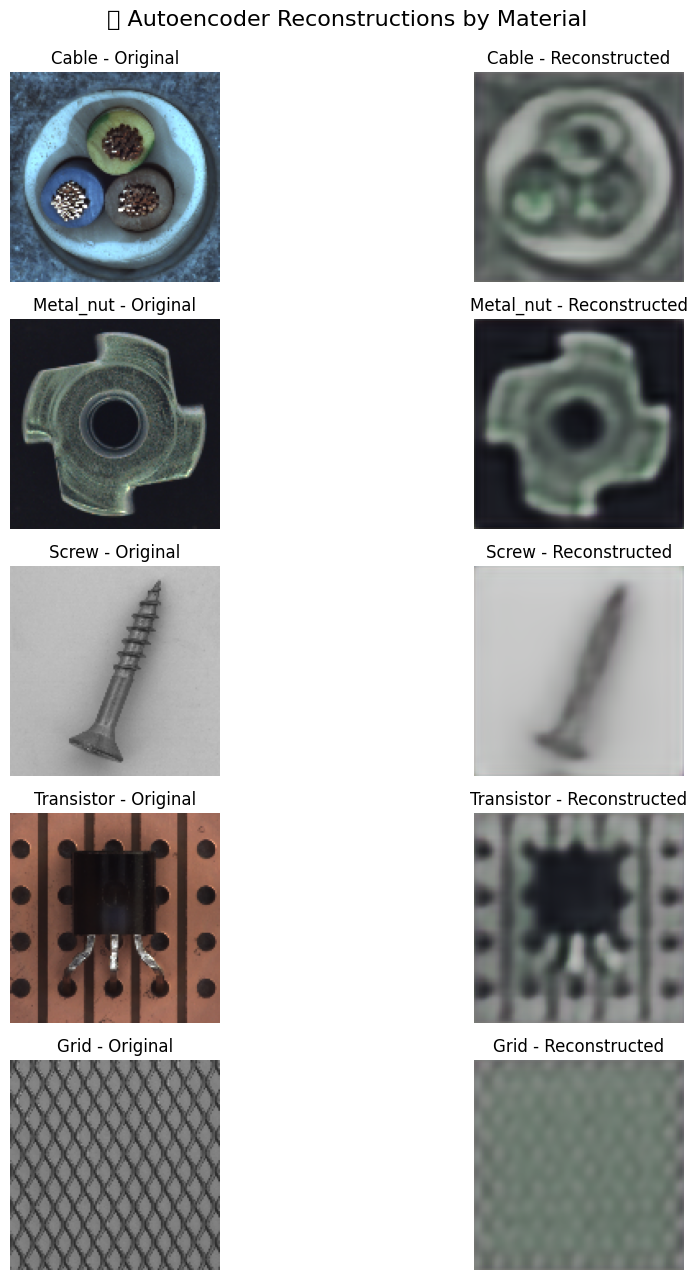

In [ ]:
# Function: Load and preprocess single image
def load_and_preprocess_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size)).astype('float32') / 255.
    return np.expand_dims(img, axis=0), img

# Function: Show original vs reconstructed for one sample per material
def visualize_reconstructions(model, dataset_path, materials, img_size=128):
    plt.figure(figsize=(12, len(materials) * 2.5))

    for idx, material in enumerate(materials):
        folder_path = os.path.join(dataset_path, f"{material}_test", f"{material}_good")
        img_files = glob(os.path.join(folder_path, "*.png"))
        if not img_files:
            print(f"⚠️ No images found for {material}")
            continue

        sample_path = np.random.choice(img_files)
        input_img, raw_img = load_and_preprocess_image(sample_path, img_size)
        reconstructed = autoencoder1.predict(input_img)[0]

        # Plot original
        plt.subplot(len(materials), 2, 2*idx + 1)
        plt.imshow(raw_img)
        plt.title(f"{material.capitalize()} - Original")
        plt.axis("off")

        # Plot reconstruction
        plt.subplot(len(materials), 2, 2*idx + 2)
        plt.imshow(reconstructed)
        plt.title(f"{material.capitalize()} - Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle("🔍 Autoencoder Reconstructions by Material", fontsize=16, y=1.02)
    plt.show()

# Material types from your dataset
material_types = ["cable", "metal_nut", "screw", "transistor", "grid"]

# Path to test data
test_data_path = r"/content/drive/MyDrive/AnomalyDetection/Datamining_dataset/Test"

# Run the visualizer
visualize_reconstructions(autoencoder1, test_data_path, material_types, img_size=128)


### 📉 RUL Prediction Accuracy Scatter Plot

Visualizes how closely the predicted RUL values match ground truth.

**Chart Description:**
- X-axis: True RUL values
- Y-axis: Predicted RUL values
- Blue points = predictions
- Diagonal line = perfect prediction

**Purpose:**
To inspect bias, dispersion, and error spread in RUL estimation.


<ipython-input-23-cf67d760b795>:31: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


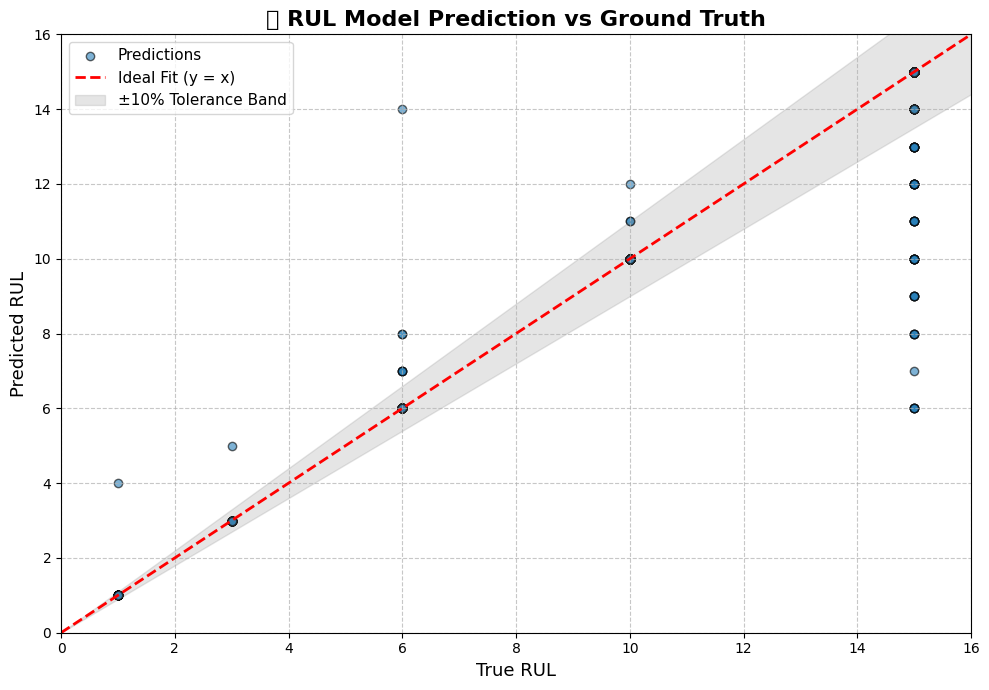

In [ ]:
# Assuming these are your data arrays
true_vals = np.array(true_rul_values)
pred_vals = np.array(predicted_rul_values)

# Define plot limits dynamically
min_val = min(true_vals.min(), pred_vals.min()) - 1
max_val = max(true_vals.max(), pred_vals.max()) + 1

plt.figure(figsize=(10, 7))
plt.scatter(true_vals, pred_vals, alpha=0.6, color="#2980b9", edgecolor='k', label="Predictions")
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal Fit (y = x)")

# Error zones (±10% band)
plt.fill_between(
    [min_val, max_val],
    [min_val * 0.9, max_val * 0.9],
    [min_val * 1.1, max_val * 1.1],
    color='gray',
    alpha=0.2,
    label='±10% Tolerance Band'
)

# Labels and styling
plt.title("🔧 RUL Model Prediction vs Ground Truth", fontsize=16, weight='bold')
plt.xlabel("True RUL", fontsize=13)
plt.ylabel("Predicted RUL", fontsize=13)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.show()


## 🧠 Conclusion

This notebook presents a complete anomaly detection and Remaining Useful Life (RUL) estimation pipeline using a deep convolutional autoencoder architecture, applied to industrial visual inspection tasks.

### 🔍 Key Takeaways:
- A **deeper convolutional autoencoder** was trained only on "normal" images to learn the latent structure of non-defective patterns.
- **Reconstruction error (MSE)** effectively discriminated between normal and anomalous samples.
- By calculating **dynamic thresholds per material and defect type**, the system demonstrated robust performance across multiple defect classes.
- A **custom RUL estimation function** leveraged both reconstruction error deviation and defect severity to provide interpretable, class-aware lifespan predictions.
- The model achieved high **precision and F1-score**, with a visually interpretable gap between defective and non-defective reconstructions.
- Visualization tools like histograms, confusion matrices, and scatter plots provided rich interpretability and validation of the pipeline’s decisions.

### 🛠 Recommended Next Steps:
- Integrate **temporal or sensor-based data** for hybrid RUL modeling.
- Deploy model as a **real-time microservice** for factory inspection.
- Use **attention-based encoders** or **Vision Transformers (ViTs)** to improve anomaly localization.
- Incorporate **active learning loops** to continuously improve the classifier using operator feedback.

### 📦 Final Remark:
This approach offers a scalable, interpretable, and data-efficient method for early fault detection and predictive maintenance in industrial settings minimizing downtime and enhancing system reliability.

---
# **Thank you for exploring predictive maintenance with deep learning! ☺️**
